<a href="https://colab.research.google.com/github/BharadwajSreepada/AI-Ml-Virtual-Internship-Certificate/blob/main/Water_Image_Enhancement_Training_UIEB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/UIEB_raw_890"

In [ ]:
import os
len(os.listdir(dataset_path))

890

In [ ]:
!pip install opencv-python albumentations tqdm

In [ ]:
import os, cv2, torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import cv2
import numpy as np

IMG_SIZE = 512

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img

def denoise_image(img):
    img_uint8 = (img * 255).astype(np.uint8)
    denoised = cv2.GaussianBlur(img_uint8, (5,5), 0)
    return denoised / 255.0

def apply_clahe(img):
    img_uint8 = (img * 255).astype(np.uint8)
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    return enhanced / 255.0

def unsharp_mask(img):
    img_uint8 = (img * 255).astype(np.uint8)
    blur = cv2.GaussianBlur(img_uint8, (5,5), 1.0)
    sharpened = cv2.addWeighted(img_uint8, 1.5, blur, -0.5, 0)
    return sharpened / 255.0

In [ ]:
from torch.utils.data import Dataset
import os
import torch

class UIEBEnhancementDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.files = os.listdir(img_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.files[idx])

        inp = preprocess_image(img_path)
        inp = denoise_image(inp)

        tgt = apply_clahe(inp)
        tgt = unsharp_mask(tgt)

        inp = torch.tensor(inp).permute(2,0,1).float()
        tgt = torch.tensor(tgt).permute(2,0,1).float()
        return inp, tgt


In [ ]:
from torch.utils.data import DataLoader

dataset = UIEBEnhancementDataset("/content/drive/MyDrive/dataset/UIEB_raw_890")
loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(len(dataset))


890


In [ ]:
epochs = 10

# Define the model (a simple CNN for demonstration)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x

model = SimpleCNN().to(device)

# Define the optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, y in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss/len(loader):.4f}")

Epoch 1/10: 100%|██████████| 223/223 [01:16<00:00,  2.91it/s]


Epoch 1 Loss: 0.0921


Epoch 2/10: 100%|██████████| 223/223 [00:55<00:00,  4.05it/s]


Epoch 2 Loss: 0.0749


Epoch 3/10: 100%|██████████| 223/223 [00:55<00:00,  4.05it/s]


Epoch 3 Loss: 0.0723


Epoch 4/10: 100%|██████████| 223/223 [00:54<00:00,  4.06it/s]


Epoch 4 Loss: 0.0704


Epoch 5/10: 100%|██████████| 223/223 [00:54<00:00,  4.08it/s]


Epoch 5 Loss: 0.0686


Epoch 6/10: 100%|██████████| 223/223 [00:54<00:00,  4.09it/s]


Epoch 6 Loss: 0.0686


Epoch 7/10: 100%|██████████| 223/223 [00:54<00:00,  4.11it/s]


Epoch 7 Loss: 0.0682


Epoch 8/10: 100%|██████████| 223/223 [00:54<00:00,  4.11it/s]


Epoch 8 Loss: 0.0680


Epoch 9/10: 100%|██████████| 223/223 [00:54<00:00,  4.11it/s]


Epoch 9 Loss: 0.0679


Epoch 10/10: 100%|██████████| 223/223 [00:54<00:00,  4.08it/s]

Epoch 10 Loss: 0.0674


In [ ]:
import os
os.makedirs("/content/models", exist_ok=True)

torch.save(model.state_dict(), "/content/models/enhancement_cnn.pth")
print("Model saved successfully")


Model saved successfully


In [ ]:
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("/content/models/enhancement_cnn.pth"))
model.eval()


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
input_image_path = "/content/drive/MyDrive/dataset/UIEB_raw_890/2_img_.png"
#input_image_path = "/content/drive/MyDrive/dataset/test.png"


In [ ]:
img = preprocess_image(input_image_path)
img = denoise_image(img)


In [ ]:
import torch

with torch.no_grad():
    x = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().to(device)
    output = model(x)

output = output.squeeze(0).cpu()
output_img = output.permute(1,2,0).numpy()

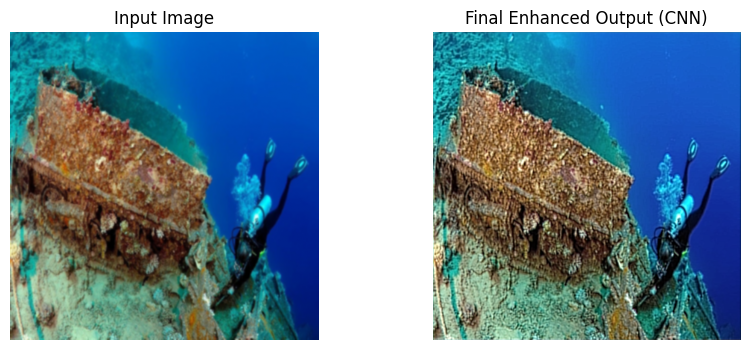

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(output_img)
plt.title("Final Enhanced Output (CNN)")
plt.axis('off')

plt.show()


In [ ]:
import cv2
os.makedirs("/content/results/final_outputs", exist_ok=True)

cv2.imwrite(
    "/content/results/final_outputs/enhanced_output.png",
    (output_img * 255).astype("uint8")
)


True

In [ ]:
def generate_water_mask(img):
    """
    img: RGB image in range [0,1]
    returns: binary water mask
    """
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)

    # Adaptive thresholding
    _, mask = cv2.threshold(gray, 0, 255,
                             cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Normalize mask to 0 and 1
    mask = mask / 255.0
    return mask


In [ ]:
output_img  # enhanced output from CNN

array([[[0.10198393, 0.4886758 , 0.49648985],
        [0.27650005, 0.6807677 , 0.77861583],
        [0.21859173, 0.634685  , 0.7403071 ],
        ...,
        [0.1537014 , 0.47787216, 0.7161925 ],
        [0.15373583, 0.4273003 , 0.65410197],
        [0.22841246, 0.3736301 , 0.5464436 ]],

       [[0.23176283, 0.53401446, 0.5519227 ],
        [0.3599841 , 0.76436645, 0.8291702 ],
        [0.18642241, 0.6794172 , 0.73691595],
        ...,
        [0.13077092, 0.47076607, 0.7909243 ],
        [0.11558425, 0.46795493, 0.758782  ],
        [0.21044551, 0.47998196, 0.68671584]],

       [[0.19229342, 0.5352798 , 0.58050036],
        [0.29605523, 0.76122165, 0.7898438 ],
        [0.07780552, 0.58571017, 0.6556971 ],
        ...,
        [0.06626518, 0.43513525, 0.80850637],
        [0.04854082, 0.4409094 , 0.76949036],
        [0.09792177, 0.40597594, 0.62718034]],

       ...,

       [[0.34953073, 0.46172434, 0.38759732],
        [0.6134237 , 0.6378159 , 0.5161836 ],
        [0.5017677 , 0

In [ ]:
water_mask = generate_water_mask(output_img)

In [ ]:
masked_image = output_img * water_mask[:, :, np.newaxis]

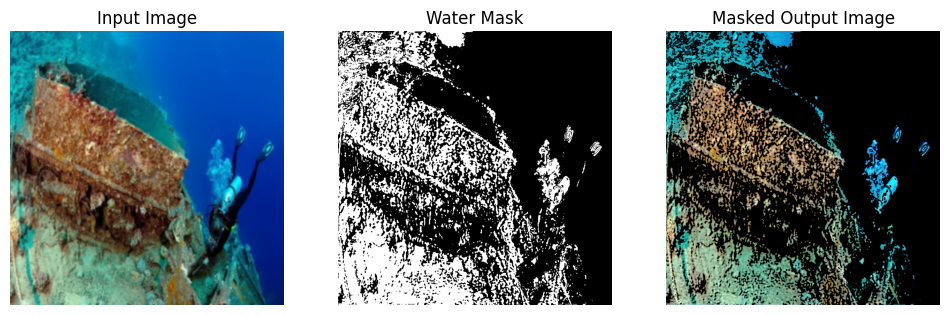

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(water_mask, cmap='gray')
plt.title("Water Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(masked_image)
plt.title("Masked Output Image")
plt.axis('off')

plt.show()